# Dataset

https://champlaincollege-st-lambert.moodle.decclic.qc.ca/pluginfile.php/683649/question/questiontext/261838/1/723789/insurance.csv



The dataset we are going to use for this quiz is named " insurance.csv" which has the following columns

Age: Age of the customers, integertype data

Sex: Gender of the customers, stringType data

bmi: FloatType data

children: no of dependents in the family, IntegerType data

smoker: does the customer, stringType data

region: stringType data

charges: Total insurance amount need to pay by the customer FloatType



The string columns need to normalize as well as the large data column. You have to map the string terms to the following regular numercial format:



Sex: male -> 1, female -> 0 

smoker: yes -> 1, no -> 0

region: southeast -> 0, southwest -> 1, northeast -> 2, northwest -> 3 



Also need to normalize bmi and charges in such a way that you get the resulted table (hint: one column needs to divide by 30 and another column needs to divide by 10000)



If you properly load the data, it will create a dataframe as it looks over here:


+---+------+------+--------+------+---------+---------+
|age|   sex|   bmi|children|smoker|   region|  charges|
+---+------+------+--------+------+---------+---------+
| 19|female|  27.9|       0|   yes|southwest|16884.924|
| 18|  male| 33.77|       1|    no|southeast|1725.5522|
| 28|  male|  33.0|       3|    no|southeast| 4449.462|
| 33|  male|22.705|       0|    no|northwest| 21984.47|
| 32|  male| 28.88|       0|    no|northwest|3866.8552|
+---+------+------+--------+------+---------+---------+
After proper normalization as I have mentioned over here, it will be following:

+---+---+----+--------+------+------+-------+
|age|sex| bmi|children|smoker|region|charges|
+---+---+----+--------+------+------+-------+
| 19|  0|0.75|       0|     1|     1| 1.6885|
| 18|  1|0.91|       1|     0|     0| 0.1726|
| 28|  1|0.89|       3|     0|     0| 0.4449|
| 33|  1|0.61|       0|     0|     3| 2.1984|
| 32|  1|0.78|       0|     0|     3| 0.3867|
+---+---+----+--------+------+------+-------+

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer, IndexToString, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors

from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, RandomForestRegressor
from pyspark.ml.feature import VectorIndexer, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

ss = SparkSession.builder.master("local[4]").appName("insurance-csv").getOrCreate()

schema = StructType([
    StructField("age", IntegerType(), nullable=True),
    StructField("sex", StringType(), nullable=True),
    StructField("bmi", FloatType(), nullable=True),
    StructField("children", IntegerType(), nullable=True),
    StructField("smoker", StringType(), nullable=True),
    StructField("region", StringType(), nullable=True),
    StructField("charges", FloatType(), nullable=True),
])

insuranceDF = ss.read.csv("insurance.csv", header=True, schema=schema)
insuranceDF.show(n=5, truncate=False)
insuranceDF = insuranceDF.withColumn("sex", F.when(col("sex") == "male", 1).otherwise(0))
insuranceDF = insuranceDF.withColumn("smoker", F.when(col("smoker") == "yes", 1).otherwise(0))
insuranceDF = insuranceDF.withColumn("region", F.when(col("region") == "southeast", 0)
                                                .when(col("region") == "southwest", 1)
                                                .when(col("region") == "northeast", 2)
                                                .when(col("region") == "northwest", 3))
                                     
insuranceDF = insuranceDF.withColumn("bmi", col("bmi") / 30)
insuranceDF = insuranceDF.withColumn("bmi", F.round("bmi",2))
insuranceDF = insuranceDF.withColumn("charges", col("charges") / 10000)
insuranceDF = insuranceDF.withColumn("charges", F.round("charges",4))

insuranceDF.show(n=5, truncate=False)
!pip install -q dtreeviz

+---+------+------+--------+------+---------+---------+
|age|sex   |bmi   |children|smoker|region   |charges  |
+---+------+------+--------+------+---------+---------+
|19 |female|27.9  |0       |yes   |southwest|16884.924|
|18 |male  |33.77 |1       |no    |southeast|1725.5522|
|28 |male  |33.0  |3       |no    |southeast|4449.462 |
|33 |male  |22.705|0       |no    |northwest|21984.47 |
|32 |male  |28.88 |0       |no    |northwest|3866.8552|
+---+------+------+--------+------+---------+---------+
only showing top 5 rows

+---+---+----+--------+------+------+-------+
|age|sex|bmi |children|smoker|region|charges|
+---+---+----+--------+------+------+-------+
|19 |0  |0.93|0       |1     |1     |1.6885 |
|18 |1  |1.13|1       |0     |0     |0.1726 |
|28 |1  |1.1 |3       |0     |0     |0.4449 |
|33 |1  |0.76|0       |0     |3     |2.1984 |
|32 |1  |0.96|0       |0     |3     |0.3867 |
+---+---+----+--------+------+------+-------+
only showing top 5 rows



Using the dataframe you have derived in question 1, can you predict the insurance charges of each customer based on their ages using LinearRegression? 

You should use all the other columns. such as age, sex bmi, children, smoker, region as features for your generating prediction.

If properly trained and regressed, you should get the following graph.

+---+---+----+--------+------+------+-------+---------------------------+
|age|sex|bmi |children|smoker|region|charges|features                   |
+---+---+----+--------+------+------+-------+---------------------------+
|19 |0  |0.93|0       |1     |1     |1.6885 |[19.0,0.0,0.93,0.0,1.0,1.0]|
|18 |1  |1.13|1       |0     |0     |0.1726 |[18.0,1.0,1.13,1.0,0.0,0.0]|
|28 |1  |1.1 |3       |0     |0     |0.4449 |[28.0,1.0,1.1,3.0,0.0,0.0] |
|33 |1  |0.76|0       |0     |3     |2.1984 |[33.0,1.0,0.76,0.0,0.0,3.0]|
|32 |1  |0.96|0       |0     |3     |0.3867 |[32.0,1.0,0.96,0.0,0.0,3.0]|
|31 |0  |0.86|0       |0     |0     |0.3757 |(6,[0,2],[31.0,0.86])      |
|46 |0  |1.11|1       |0     |0     |0.8241 |[46.0,0.0,1.11,1.0,0.0,0.0]|
|37 |0  |0.92|3       |0     |3     |0.7282 |[37.0,0.0,0.92,3.0,0.0,3.0]|
|37 |1  |0.99|2       |0     |2     |0.6406 |[37.0,1.0,0.99,2.0,0.0,2.0]|
|60 |0  |0.86|0       |0     |3     |2.8923 |[60.0,0.0,0.86,0.0,0.0,3.0]|
|25 |1  |0.87|0       |0     |2     |0

DenseVector([0.1367, 0.0, 0.0, 0.0, 0.7107, 0.0])

0.5862157560718464

+---+-------+------------------+
|age|charges|       predCharges|
+---+-------+------------------+
| 18| 0.1608|0.7613772662897607|
| 18| 0.2201|0.7613772662897607|
| 18| 0.7324|0.7613772662897607|
| 18| 0.2204|0.7613772662897607|
| 18| 0.1632|0.7613772662897607|
| 18| 0.1633|0.7613772662897607|
| 18| 0.1634|0.7613772662897607|
| 18| 1.1884|0.7613772662897607|
| 18| 0.1705|0.7613772662897607|
| 18| 0.1709|0.7613772662897607|
| 18| 0.1719|0.7613772662897607|
| 18| 0.1136|0.7613772662897607|
| 18| 0.1137|0.7613772662897607|
| 18| 0.1149|0.7613772662897607|
| 19| 0.1737| 0.771108461301867|
| 19| 1.7081|2.5316645322482563|
| 19| 0.2332| 0.771108461301867|
| 19| 1.7749|2.5316645322482563|
| 19| 3.3308|2.5316645322482563|
| 19|  2.406| 0.771108461301867|
+---+-------+------------------+
only showing top 20 rows



<AxesSubplot: xlabel='age', ylabel='charges'>

<AxesSubplot: xlabel='age', ylabel='charges'>

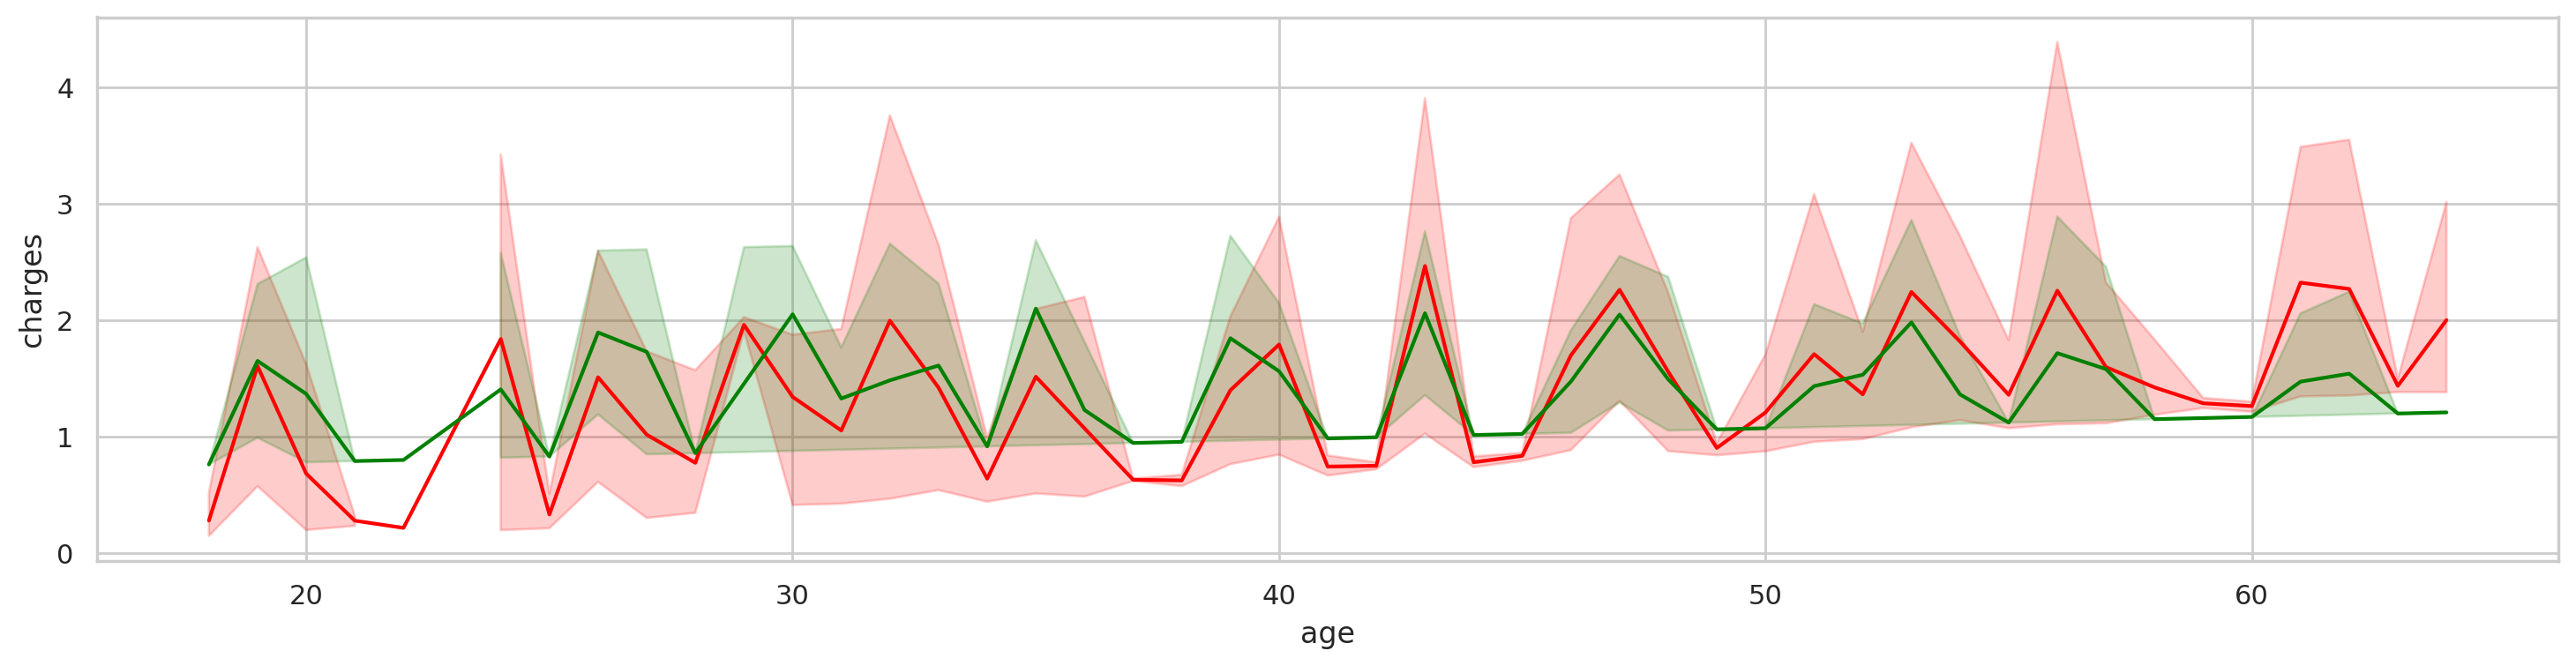

In [2]:
featureCols = ["age","sex","bmi","children","smoker","region"]

vecAssem = VectorAssembler(inputCols=featureCols, outputCol="features", handleInvalid="skip")
assembledDF = vecAssem.transform(insuranceDF)
assembledDF.show(14, truncate=False)

stanScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaledDF = stanScaler.fit(assembledDF).transform(assembledDF)
scaledDF.select("features", "features_scaled").show(15, truncate=False)

trainData, testData = scaledDF.randomSplit([0.8, 0.2], seed=rnd_seed)
lr = (LinearRegression(featuresCol='features_scaled', labelCol="charges", predictionCol='predCharges', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

linearModel = lr.fit(trainData)
linearModel.coefficients
linearModel.intercept

coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]
predictions = linearModel.transform(testData)
predAgeAndCharges = predictions.select("age","charges","predCharges")
predAgeAndCharges.show()

ageChargeDF = predictions.select(["age","charges","predCharges"]).sample(False, 0.7, 42)
ageChargeDFPandas = ageChargeDF.toPandas()
sns.lineplot(x = "age", y = "charges", data = ageChargeDFPandas, color = "red")
sns.lineplot(x = "age", y = "predCharges", data = ageChargeDFPandas, color = "green")

For the same problem given in question 2, can you redo the solution of the same problem with RandomForestRegressor?



+---+---+----+--------+------+------+-------+
|age|sex| bmi|children|smoker|region|charges|
+---+---+----+--------+------+------+-------+
| 18|  0|0.69|       0|     0|     0| 0.1608|
| 18|  0|0.72|       0|     1|     2| 1.4283|
| 18|  0| 0.8|       1|     0|     0| 0.2201|
| 18|  0|0.84|       0|     0|     2| 0.2196|
| 18|  0|0.89|       0|     0|     0| 0.1616|
| 18|  0|0.94|       0|     0|     2| 0.2201|
| 18|  0| 1.0|       0|     0|     2| 0.2203|
| 18|  0| 1.0|       0|     0|     2| 2.1345|
| 18|  0|1.01|       0|     0|     2| 0.2204|
| 18|  0|1.05|       0|     0|     0| 0.1622|
| 18|  0|1.05|       4|     0|     2| 0.4561|
| 18|  0|1.06|       0|     0|     2| 0.2206|
| 18|  0|1.11|       0|     0|     2| 0.2208|
| 18|  0|1.19|       0|     0|     2| 0.2211|
| 18|  0|1.23|       0|     1|     0| 3.6149|
| 18|  0|1.27|       0|     0|     0| 0.1632|
| 18|  0|1.31|       0|     0|     0| 0.1633|
| 18|  0|1.33|       0|     0|     0| 0.1634|
| 18|  0|1.34|       0|     0|    

<AxesSubplot: xlabel='age', ylabel='charges'>

<AxesSubplot: xlabel='age', ylabel='charges'>

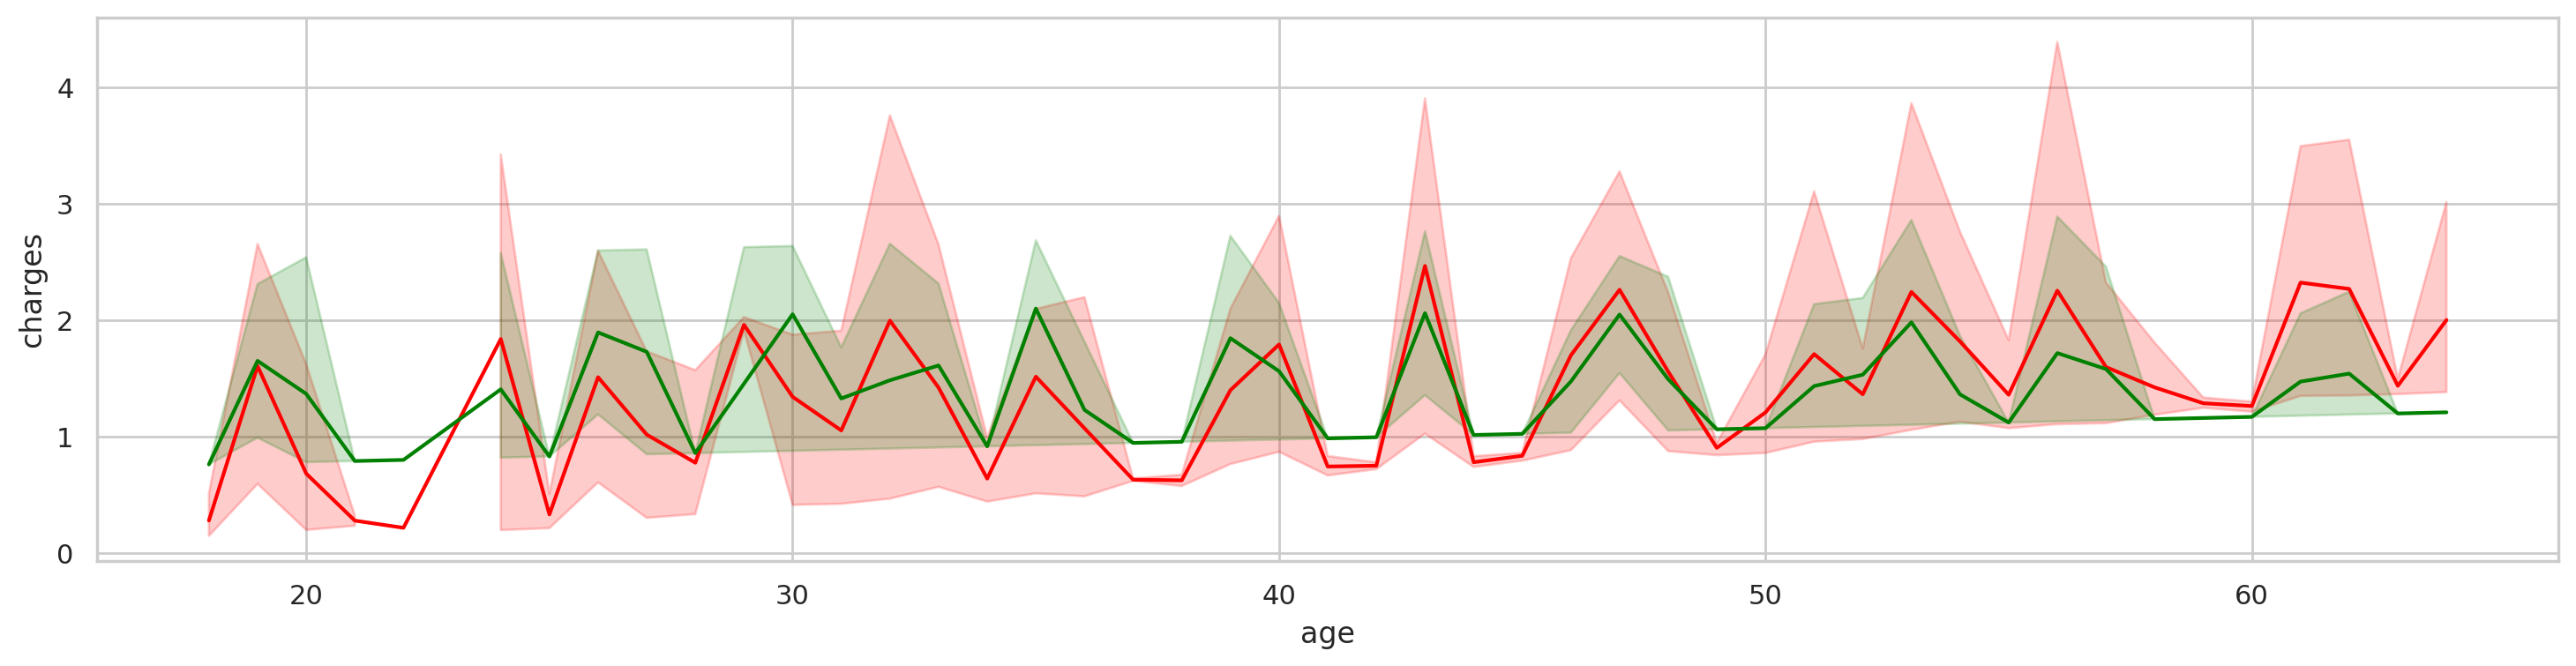

In [11]:
featureCols = ["age","sex","bmi","children","smoker","region"]
target = "charges"

(trainingDataRF,testingDataRF) = insuranceDF.randomSplit([.7,.3])
trainingDataRF.show()
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(trainingDataRF) for column in featureCols]
stage = indexers

vectorAssembler = VectorAssembler(inputCols=featureCols, outputCol="features", handleInvalid="skip")
stage.append(vectorAssembler)

randomForestrg = RandomForestRegressor(featuresCol="features", labelCol=target, predictionCol="predCharges")
stage.append(randomForestrg)

pipeline = Pipeline().setStages(stage)

model = pipeline.fit(trainingDataRF)
predictions = model.transform(testingDataRF)
predictions.select("age","charges","predCharges","features").show(5, truncate=False)

ageChargesDF = predictions.select(["age","charges","predCharges"]).sample(False, 0.7, 42)
ageChargesDFPandas = ageChargesDF.toPandas()
sns.lineplot(x = "age", y = "charges", data = ageChargeDFPandas, color = "red")
sns.lineplot(x = "age", y = "predCharges", data = ageChargeDFPandas, color = "green")
